# Intro

We're going to start with some housing data that includes features of a house and the sale price. We want to create a model using regression that predicts the price of a new house given some or all of the important features. We will first dome some general data exploration, clean our data up, then create our model.

In [238]:
# Import modules we'll need
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [319]:
# Import data
houses_dirty_train = pd.read_csv('train.csv')
print(houses_dirty_train['GrLivArea'].describe())
print(houses_dirty_train['SalePrice'].describe())

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [240]:
# Let's get an idea for the different values that we can expect to see for each column.
for house in houses_dirty_train:
    print(house, houses_dirty_train[house].unique()[0:5])

Id [1 2 3 4 5]
MSSubClass [ 60  20  70  50 190]
MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']
LotFrontage [65. 80. 68. 60. 84.]
LotArea [ 8450  9600 11250  9550 14260]
Street ['Pave' 'Grvl']
Alley [nan 'Grvl' 'Pave']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer']
OverallQual [7 6 8 5 9]
OverallCond [5 8 6 7 4]
YearBuilt [2003 1976 2001 1915 2000]
YearRemodAdd [2003 1976 2002 1970 2000]
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace']
Exterior2nd ['VinylSd' '

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Kurtosis:  6.536281860064529
Skewness:  1.8828757597682129


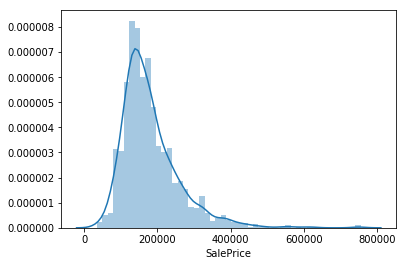

In [241]:
# Let's look more closely at the distribution of the sale price, what we want to predict
print(houses_dirty_train['SalePrice'].describe())
print('Kurtosis: ', houses_dirty_train['SalePrice'].kurtosis())
print('Skewness: ', houses_dirty_train['SalePrice'].skew())
sns.distplot(houses_dirty_train['SalePrice']);

Text(0, 0.5, 'Sale Price ($)')

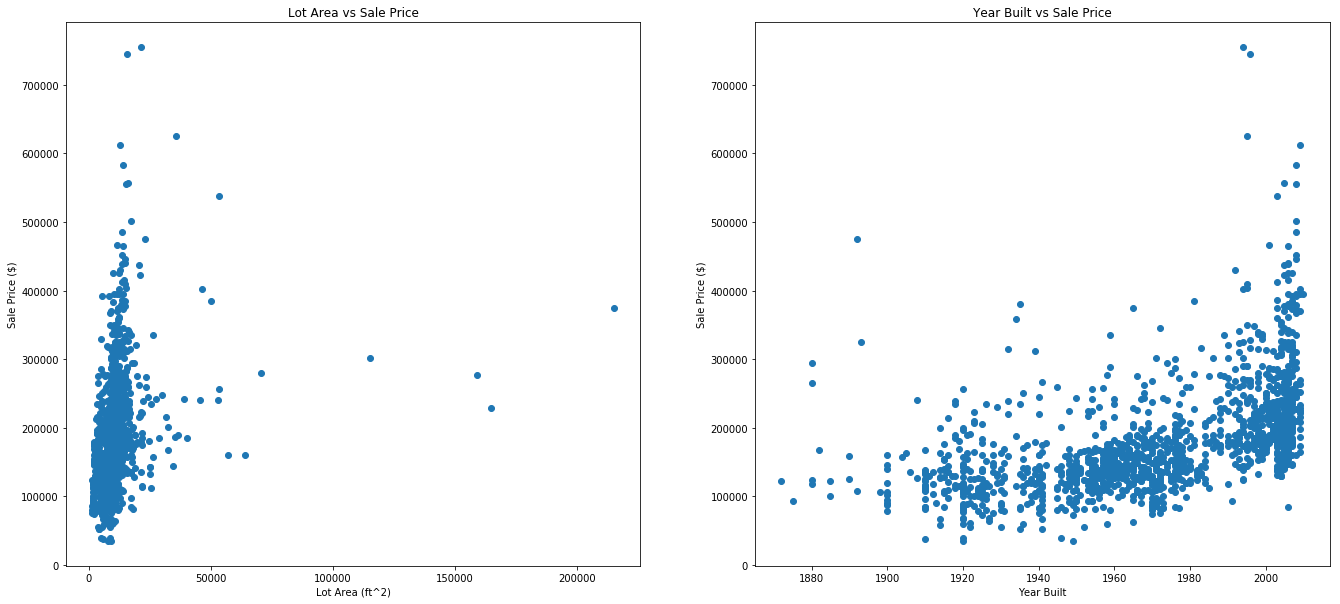

In [242]:
# Looks like sale price is pretty skewed to the right.
# How does sale price relate to some of our other features?
plt.figure(figsize=(35, 10))

plt.subplot(131)
plt.scatter(houses_dirty_train['LotArea'], houses_dirty_train['SalePrice'])
plt.title("Lot Area vs Sale Price")
plt.xlabel("Lot Area (ft^2)")
plt.ylabel("Sale Price ($)")

plt.subplot(132)
plt.scatter(houses_dirty_train['YearBuilt'], houses_dirty_train['SalePrice'])
plt.title("Year Built vs Sale Price")
plt.xlabel("Year Built")
plt.ylabel("Sale Price ($)")

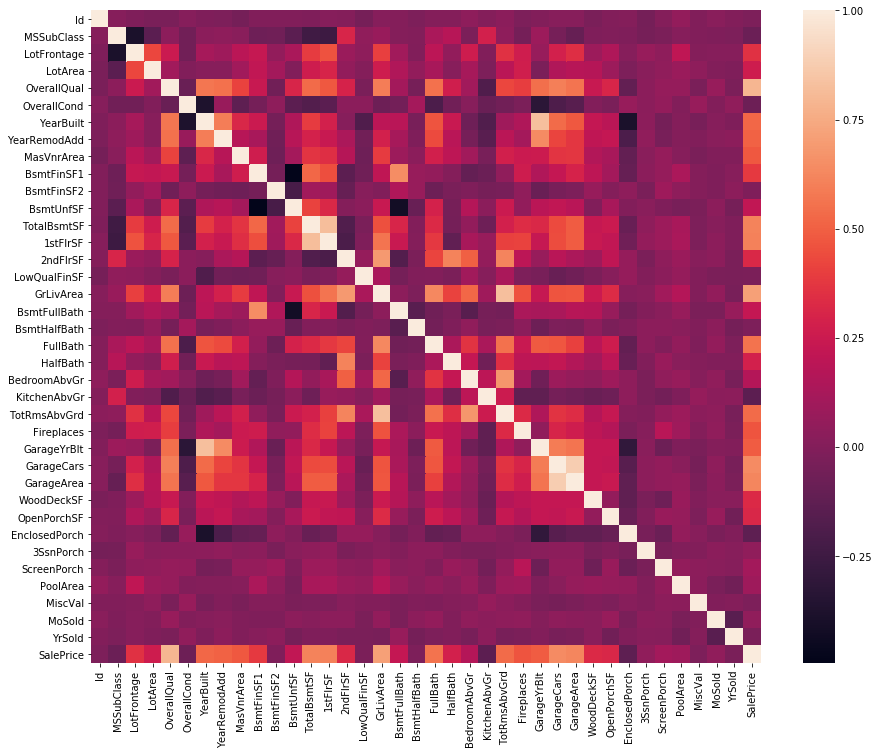

In [243]:
# Let's take a broader view

corrmat = houses_dirty_train.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat);

In [244]:
# Now we want to focus in on some of the more important features, but first we need to figure out what they are!
# Let's focus on the sale price and see what is most strongly correlated with it.

print(corrmat['SalePrice'].sort_values())

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

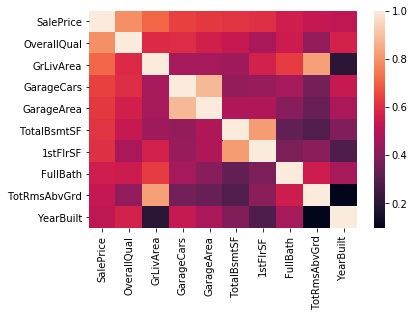

In [245]:
# While some of these correlate with eachother well, note that some are likely to correlate streonly with eachother.
# Thus we can reduce the number of features we'll look at by looking at how each of these are correlated with eachother.

cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(houses_dirty_train[cols].values.T)
hm = sns.heatmap(cm, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

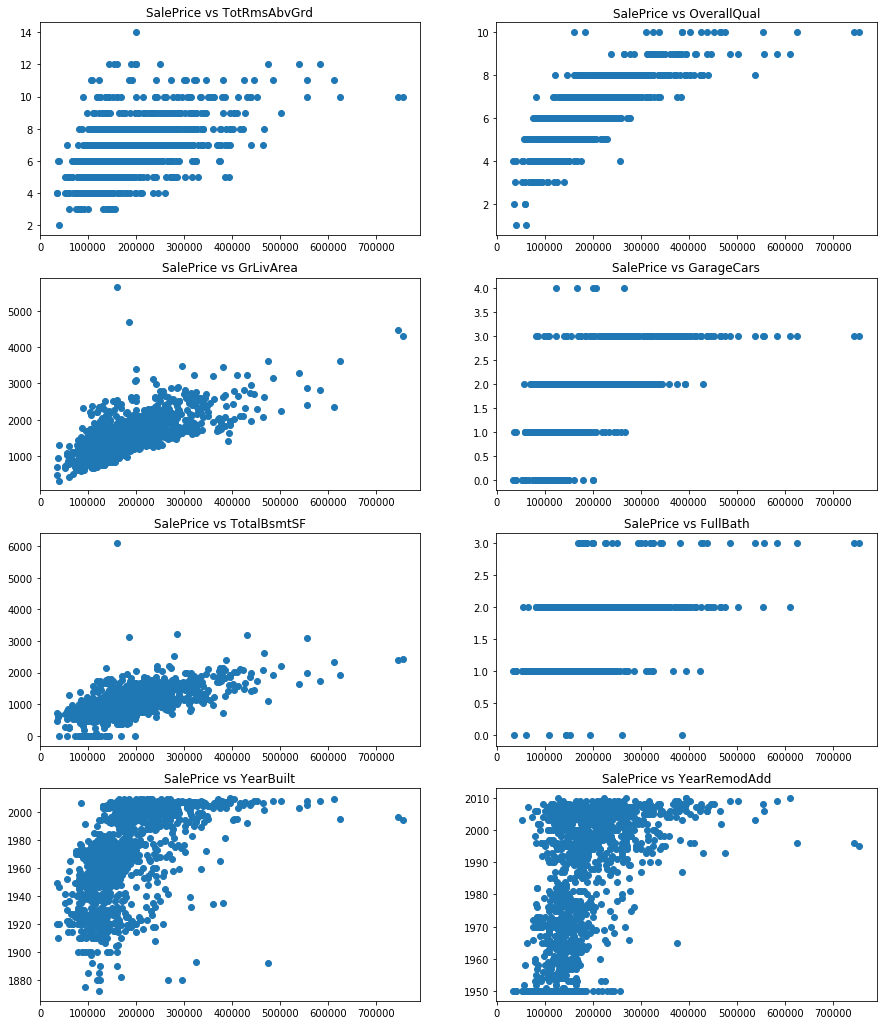

In [246]:
# Let's look at the distributions of each vs sale price

fig, axs = plt.subplots(4, 2, figsize=(15,18))
columns = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd']


for i in list(range(4)):
    for j in list(range(2)):
        axs[i,j].scatter(houses_dirty_train['SalePrice'], houses_dirty_train[columns[(i*2-1)+j]])
        axs[i,j].set_title('SalePrice vs ' + columns[(i*2-1)+j])
        

In [247]:
# Looks like there are two very expensive outliers on the right in each graph. These two 
# are very expensive, high quality, very large, 3 garage, 3 baths, buily and remodeled 
# recently. Let's remove these from out data.

houses_dirty_train.sort_values(by = 'SalePrice', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [248]:
houses_dirty_train = houses_dirty_train.drop(houses_dirty_train[houses_dirty_train['Id'] == 692 ].index)
houses_dirty_train = houses_dirty_train.drop(houses_dirty_train[houses_dirty_train['Id'] == 1183].index)

Skewness:  1.5673206992654365


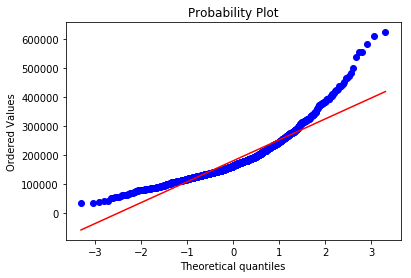

In [249]:
# Let's take another look at our data
fig = plt.figure()
res = stats.probplot(houses_dirty_train['SalePrice'], plot=plt)
print('Skewness: ', houses_dirty_train['SalePrice'].skew())

Skewness:  0.06515785284022292


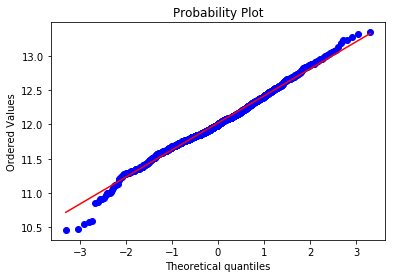

In [250]:
# Since we have have positive skewness we can use a log transform to normalize our data

houses_dirty_train['SalePrice'] = np.log(houses_dirty_train['SalePrice'])
res = stats.probplot(houses_dirty_train['SalePrice'], plot=plt)
print('Skewness: ', houses_dirty_train['SalePrice'].skew())

In [251]:
# Much better! Now let's check the features

print('Skewness: ', houses_dirty_train[columns].skew())

Skewness:  OverallQual     0.200786
GrLivArea       1.236562
GarageCars     -0.343629
TotalBsmtSF     1.524893
FullBath        0.023248
YearBuilt      -0.611256
YearRemodAdd   -0.501561
TotRmsAbvGrd    0.677550
dtype: float64


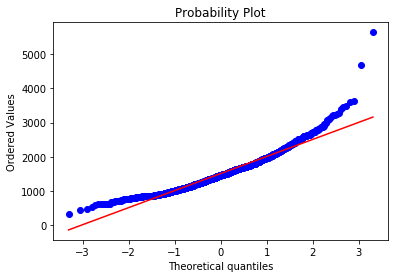

In [252]:
res = stats.probplot(houses_dirty_train['GrLivArea'], plot=plt)

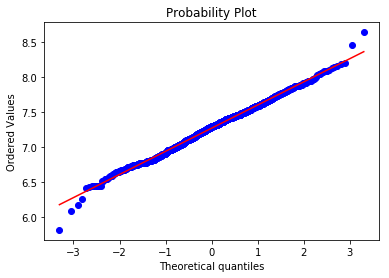

In [253]:
# We can apply our same trick to GrLivArea
houses_dirty_train['GrLivArea'] = np.log(houses_dirty_train['GrLivArea'])
res = stats.probplot(houses_dirty_train['GrLivArea'], plot=plt)

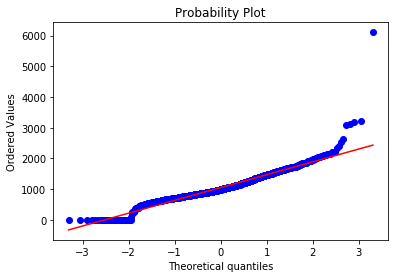

In [254]:
# Beautiful! Now let's check TotalBsmtSF. This is a little trickier since we can't use log since we have 0's. 
# We can try using square root or cube root but those won't get us very far. So we'll leave that for now.

res = stats.probplot(houses_dirty_train['TotalBsmtSF'], plot=plt)

In [267]:
# Now let's make our clean dataframe to build our regression model!

houses_features_train = houses_dirty_train[columns]
houses_target_train = houses_dirty_train['SalePrice']
for feature in houses_features_train:
    print(feature)
    print(houses_features_train[feature].describe())
    print("\n")
print('SalePrice')
print(houses_target_train.describe())

OverallQual
count    1458.000000
mean        6.093964
std         1.376369
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64


GrLivArea
count    1458.000000
mean        7.266237
std         0.331183
min         5.811141
25%         7.028644
50%         7.287217
75%         7.482119
max         8.637994
Name: GrLivArea, dtype: float64


GarageCars
count    1458.000000
mean        1.765432
std         0.746430
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64


TotalBsmtSF
count    1458.000000
mean     1055.560357
std       436.089145
min         0.000000
25%       795.250000
50%       991.000000
75%      1296.750000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


FullBath
count    1458.000000
mean        1.563100
std         0.548721
min         0.000000
25%         1.000000
50%         2.000000
75%    

In [274]:
sale_price_estimator = linear_model.LinearRegression()
sale_price_estimator.fit(houses_features_train, houses_target_train)
pred = sale_price_estimator.predict(houses_features_train)
print("Our MSE is {}, that's pretty good!".format(mean_squared_error(pred, houses_target_train)))

Our MSE is 0.027126559349654494, that's pretty good!
<class 'pandas.core.frame.DataFrame'>


In [291]:
# Now we can test our model to see what kind of values we get:
OverallQual = 8
GrLivArea = 1500
GarageCars = 1
TotalBsmtSF = 1055
FullBath = 2
YearBuilt = 1971
YearRemodAdd = 1984
TotRmsAbvGrd = 6
print(
    "The expected sales price for this house is $" +
    str(round(np.exp(sale_price_estimator.predict([[OverallQual, np.log(GrLivArea), GarageCars, TotalBsmtSF, FullBath, YearBuilt, YearRemodAdd, TotRmsAbvGrd]]))[0],2))
)

The expected sales price for this house is $185590.3
6.093964334705076


In [298]:
# Let's generalize this and make a function that takes in any number of these parameters and returns the estimated 
# sale price. If we don't get a value passed, we're going to assume it's average.

def estimate_price(OverallQual=houses_features_train['OverallQual'].mean(), 
                   GrLivArea=np.exp(houses_features_train['GrLivArea'].mean()), 
                   GarageCars=houses_features_train['GarageCars'].mean(), 
                   TotalBsmtSF=houses_features_train['TotalBsmtSF'].mean(), 
                   FullBath=houses_features_train['FullBath'].mean(), 
                   YearBuilt=houses_features_train['YearBuilt'].mean(), 
                   YearRemodAdd=houses_features_train['YearRemodAdd'].mean(), 
                   TotRmsAbvGrd=houses_features_train['TotRmsAbvGrd'].mean()):
    """
    This function takes in qualities of a house and returns an expected selling price in USD.
    
    OverallQual: Overall material and finish quality. Ranges from 0 to 10.
    GrLivArea: Above grade (ground) living area square feet.
    GarageCars: Size of garage in car capacity.
    TotalBsmtSF: Total square feet of basement area.
    FullBath: Full bathrooms above grade.
    YearBuilt: Original construction date.
    YearRemodAdd: Remodel date.
    TotRmsAbvGrd: Total rooms above grade (does not include bathrooms).

    """
    return round(np.exp(sale_price_estimator.predict([[OverallQual, np.log(GrLivArea), GarageCars, TotalBsmtSF, FullBath, YearBuilt, YearRemodAdd, TotRmsAbvGrd]]))[0],2)
    

196346.43


# Conclusion

We've successfully made our model that takes in some of the most important features of a house and returns an estimate for the sale price. To do this we learned that some of the most important features when determining a house price in this data set are the general living area, size of the farage, and the overall quality of the house all of which are resonable. The model that we created has a MSE of around 0.027. Some further analysis that would be interesting is to use information such as cluster analysis on the neighborhoods. 

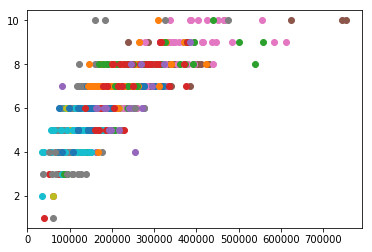

In [320]:
groups = houses_dirty_train[['SalePrice','OverallQual','Neighborhood']].groupby("Neighborhood")
groups.mean()
for name, group in groups:
    plt.plot(group["SalePrice"], group["OverallQual"], marker="o", linestyle="", label=name)